# Unsupervised exploration of Calcium 45 data

### What does this do?
This is a collection of various attempts at investigating calcium 45 experimental data
## Imports

In [1]:
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import numba as nb
from numba import jit
import os
from sklearn.cluster import KMeans
import pickle
import pyfftw

## Read in data

Figure out how large the file is and read it all in

In [7]:
s = os.stat('Run_00120_00.bin')

In [8]:
N = int((s.st_size - 8)/7033)

In [9]:
N

429600

this is the custom data type used

In [10]:
dt = np.dtype([('header', '33c'), ('wf', '3500h')])

In [11]:
with open('Run_00120_00.bin', 'rb') as file:
    theader = np.core.records.fromfile(file,formats='Q',shape=1,byteorder='<')[0][0]
    file.seek(8)
    data = np.core.records.fromfile(file, dtype=dt ,shape=N,byteorder='<')

now I need to apply some bit level logic to the data because of the way it's stored

In [12]:
@jit(nopython=True)
def bitLogic(x):
    for i in range(3500):
        x[i] &= 16383
        if x[i]>8191:
            x[i] -= 16384

In [13]:
bitLogic(np.arange(3500, dtype='h'))

In [14]:
for j in range(N):
    bitLogic(data['wf'][j])

### shuffling
this is to prevent some sort of bias from selecting data in one portion of the data

In [15]:
@jit(nopython=True)
def scramble(x):
    np.random.shuffle(x)

In [16]:
# scramble(data['wf'][:10])
# scramble(data['wf'])

In [17]:
#X = data['wf'][:100*1000]

In [18]:
data['wf'].shape

(429600, 3500)

In [19]:
data = data[:400*10**3]

In [20]:
data.shape

(400000,)

In [21]:
data['wf'] = data['wf'].astype(np.float32)

In [22]:
X = data['wf'].astype(np.float32)

## getting amplitudes
This uses the Jordanov and Knoll Trapezoidal filter derived from a derivative of the Moving Windo Deconvolution to extract the maximum

In [24]:
def amplitudes(data):
    ## Get trapezoid filter
    tau = np.int(1250)
    rise = np.int(200)
    top = np.int(100)
    trap = np.empty(3500)
    for i in range(rise):
        trap[i] = tau + i
        trap[i+rise+top] = rise - tau - i
    for i in range(rise, rise+top):
        trap[i] = rise
    for i in range(rise+top, 3500):
        trap[i] = 0
    trap = trap/(rise*tau)
    trap[rise+top:2*rise+top] = -trap[:rise]
    trapNew = np.fft.rfft(trap)

    # Get amplitudes
    f = pyfftw.interfaces.numpy_fft.irfft(pyfftw.interfaces.numpy_fft.rfft(data)*trapNew)
    E = np.amax(f, 1, keepdims=True)
    E -= np.mean(f[:,:100], 1, keepdims=True)
    return E

Because doing all 400K at once makes the computer freeze for a minute then throw a memory error

In [25]:
E = [amplitudes(X[i*10**5 : (i+1)*10**5]) for i in range(4)]

In [26]:
E = np.array(E).flatten()

In [27]:
E = np.append(E, amplitudes(X[4*10**5:]))

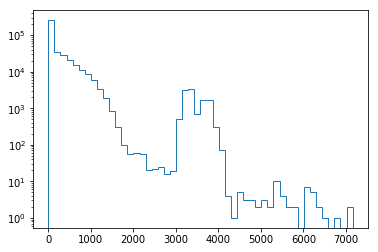

In [28]:
plt.hist(E, bins=50, histtype='step');
plt.yscale('log')

## Normalizing
Because the similarity between the two pulses is a dot product, having different scales will throw off the similarity metrics used in the unsupervised methods. I save the scaling factors to make threshold cuts and to be able to look at energies later

In [29]:
@jit(nopython=True)
def normBatch(data):
    x = data.astype(np.float32)
    for i in range(len(data)):
        x[i] = x[i] - np.amin(x[i])
        x[i] = x[i]*2./np.amax(x[i])
        x[i] = x[i] - 1
    return x

In [30]:
x = data['wf'][:20]
x = normBatch(x)
X = normBatch(X)

## K means clustering

### How many clusters should I use?

In [ ]:
maxClusters = 30
res2 = np.empty(maxClusters-2)
for numClusters in range(2,maxClusters):
    kmean = KMeans(n_clusters=numClusters, n_jobs=7).fit(X[:1000])
    res2[numClusters-2] = kmean.score(X[:1000])

In [ ]:
t = np.arange(2, maxClusters)
plt.scatter(t, -res2)
plt.yscale('log')

### 10 seems reasonable, so now let's train with all of this run

In [31]:
from sklearn.cluster import MiniBatchKMeans

In [32]:
with open('kmean', 'rb') as file:
    kmean = pickle.load(file)

In [33]:
#kmean = MiniBatchKMeans(n_clusters=10, n_init=200)

In [34]:
#kmean.fit(X);

In [35]:
#kmean = KMeans(n_clusters=10, init=kmean.cluster_centers_, n_init=1)

Even with 32 GB of RAM, training over 6 GB of data is too much

In [45]:
N2 = 4*10**5
kmean.fit(X[np.append(np.random.randint(2, size=N2), np.zeros(len(X)-N2)).astype(bool)]);

In [46]:
with open('kmean', 'wb') as file:
    pickle.dump(kmean, file)

In [47]:
kmean.labels_ = kmean.predict(X)

### Let's get energies for each of the labels so we can check out what the output looks like in terms of steepiness, also called by some as inverse fall time

In [48]:
clusterIDs = kmean.labels_

In [49]:
clusterE = [np.array([E[j] for j in range(len(X)) if clusterIDs[j]==i]) for i in range(kmean.cluster_centers_.shape[0])]

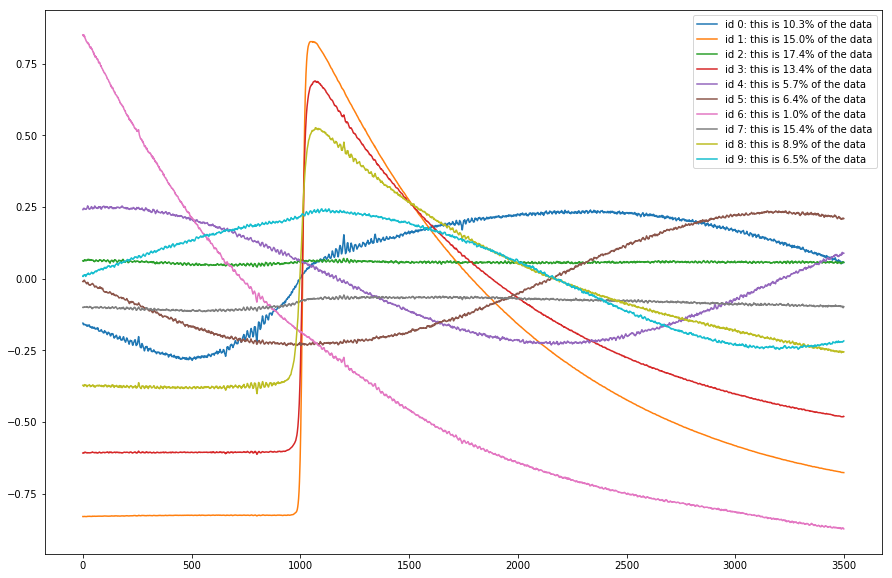

In [76]:
fig = figure(figsize=(15,10))
for i in range(kmean.cluster_centers_.shape[0]):
    plot(kmean.cluster_centers_[i], label='id '+str(i)+': this is '+str(np.around(100*len(clusterE[i])/len(data),1))+'% of the data')
legend()
savefig('slopyness.png')

### Now I want to histogram the two different pulses and see if they differ in energies
The ids I want are 1, 3, 8

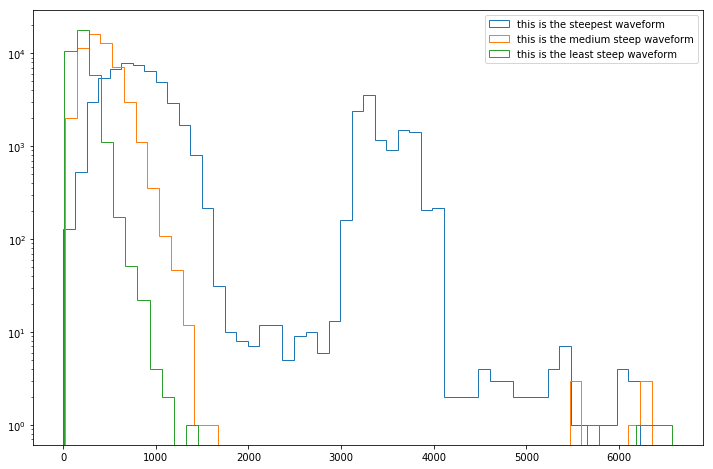

In [53]:
f = plt.figure(figsize=(12,8))
plt.hist(clusterE[1], bins=50, histtype='step', label='this is the steepest waveform')
plt.hist(clusterE[3], bins=50, histtype='step', label='this is the medium steep waveform')
plt.hist(clusterE[8], bins=50, histtype='step', label='this is the least steep waveform')
#plt.hist(clusterE[5], bins=50, histtype='step', label='this is the weird brown')

plt.yscale('log')
plt.legend();
plt.savefig('mostSteepMyDudes.png')

## What's the difference between the energy spectra of the pulsy shapes and the total spectra?

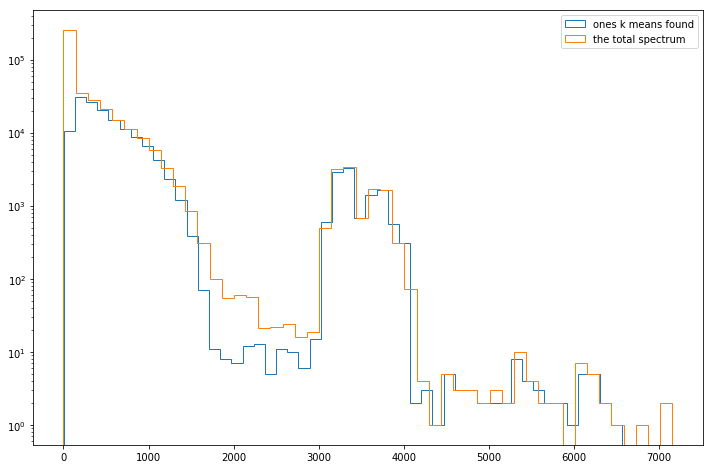

In [52]:
f = plt.figure(figsize=(12,8))

total = np.append(clusterE[1],clusterE[3])
total = np.append(total, clusterE[8])
#total = np.append(total, clusterE[5])

plt.hist(total, bins=50, histtype='step', label='ones k means found');
plt.hist(np.array([item for sublist in clusterE for item in sublist]),bins=50, histtype='step', label='the total spectrum');
#plt.hist(np.array([clusterE[i] for i in range(7) if i!=1 and i!=4]).flatten(), bins=50, histtype='step', label='ones k means didn\'t founded');
plt.yscale('log')
plt.legend();

## Now for the breakdown
* I'll look at how the data is made up of different boards and channels

In [52]:
# lookup table as described in image
pixel_to_bc = { '39W':(0,1),'62W':(1,1),'77W':(2,1),'39E':(3,1),'62E':(4,1),'77E':(5,1), \
                '40W':(0,2),'63W':(1,2),'78W':(2,2),'40E':(3,2),'63E':(4,2),'78E':(5,2), \
                '41W':(0,3),'64W':(1,3),'87W':(2,3),'41E':(3,3),'64E':(4,3),'87E':(5,3), \
                '50W':(0,4),'65W':(1,4),'88W':(2,4),'50E':(3,4),'65E':(4,4),'88E':(5,4), \
                '51W':(0,5),'66W':(1,5),'89W':(2,5),'51E':(3,5),'66E':(4,5),'89E':(5,5), \
                '52W':(0,6),'75W':(1,6),            '52E':(3,6),'75E':(4,6),       \
                '53W':(0,7),'76W':(1,7),            '53E':(3,7),'76E':(4,7) }

In [63]:
bc_to_pixel = {}
for x in pixel_to_bc.items():
    bc_to_pixel[x[1]] = x[0]

In [64]:
pixel_to_bc['51W']

(0, 5)

In [65]:
bc_to_pixel[(0,5)]

'51W'

In [54]:
dh = np.dtype([
    ('result',np.ubyte), ('event id', 'i'), 
    ('board number', 'i4'), ('channel number', 'i4'),
    ('req. timestamp',np.uint64), ('cur timestamp',np.uint64),
    ('length', 'i4')])

In [55]:
buf = data['header'].copy(order='C')

In [56]:
headerInfo = buf.view(dh)

In [57]:
headerInfo

array([[(1, 0, 1, 1, 18446744073709551346,      226054, 3500)],
       [(1, 0, 1, 3,                   10,      235820, 3500)],
       [(1, 0, 1, 4,                  166,      244532, 3500)],
       ...,
       [(1, 0, 1, 3,          42965337878, 42965516702, 3500)],
       [(1, 0, 1, 4,          42965337886, 42965529324, 3500)],
       [(1, 0, 1, 5,          42965337882, 42965542946, 3500)]],
      dtype=[('result', 'u1'), ('event id', '<i4'), ('board number', '<i4'), ('channel number', '<i4'), ('req. timestamp', '<u8'), ('cur timestamp', '<u8'), ('length', '<i4')])

In [58]:
pixelIDs = ['']*len(X)

In [77]:
for i in range(len(X)):
    x = (headerInfo[i]['board number'][0], headerInfo[i]['channel number'][0])
    if x in bc_to_pixel:
        pixelIDs[i] = bc_to_pixel[x]

In [78]:
np.unique(pixelIDs)

array(['', '39E', '39W', '40E', '40W', '41E', '41W', '50E', '50W', '51E',
       '51W', '52E', '52W', '53E', '53W', '62E', '62W', '63E', '63W',
       '64E', '64W', '65E', '65W', '66E', '66W', '75E', '75W', '76E',
       '76W', '77E', '77W', '78E', '78W', '87E', '87W', '88E', '88W',
       '89E', '89W'], dtype='<U3')

In [84]:
W64 = np.array([i for i in range(len(X)) if (kmean.labels_[i] == 1 or kmean.labels_[i] == 3 or kmean.labels_[i] == 8) and pixelIDs[i]=='64W'])

In [85]:
E64 = np.array([i for i in range(len(X)) if (kmean.labels_[i] == 1 or kmean.labels_[i] == 3 or kmean.labels_[i] == 8) and pixelIDs[i]=='64E'])

In [86]:
len(W64)

60973

In [87]:
len(E64)

65305

No handles with labels found to put in legend.


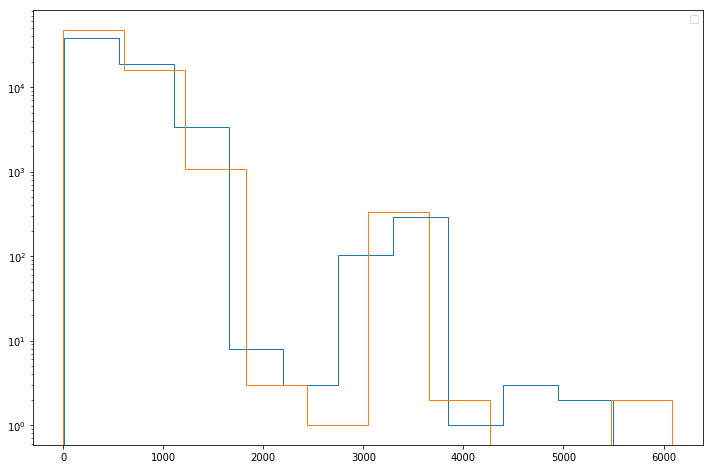

In [91]:
f = plt.figure(figsize=(12,8))

plt.hist(E[W64], histtype='step')
plt.hist(E[E64], histtype='step')

#plt.hist([E[W64][i] for i in range(len(E[W64])) if 600<=E[i]<=1400], bins=50, histtype='step', label='64W');

#plt.hist(np.array([item for sublist in clusterE for item in sublist]),bins=50, histtype='step', label='the total spectrum');
#plt.hist(np.array([clusterE[i] for i in range(7) if i!=1 and i!=4]).flatten(), bins=50, histtype='step', label='ones k means didn\'t founded');
plt.yscale('log')
plt.legend();

## Now to try a bunch of other techniques

In [123]:
IDs = [i for i in range(len(X)) if headerInfo['board number'][i][0]==1 and headerInfo['channel number'][i][0]==3]

In [120]:
k = KMeans(n_clusters=10, n_init=20)

In [125]:
k.fit(X[IDs])

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=20, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

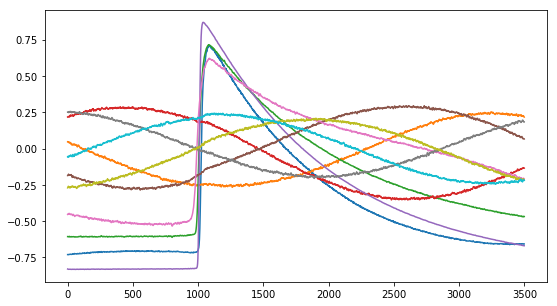

In [126]:
fig = figure(figsize=(9,5))
for i in range(k.cluster_centers_.shape[0]):
    plot(k.cluster_centers_[i])

In [127]:
IDs = [i for i in range(len(X)) if headerInfo['board number'][i][0]==1 and headerInfo['channel number'][i][0]==4]

In [128]:
k = KMeans(n_clusters=10, n_init=20)

In [129]:
k.fit(X[IDs])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=20, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

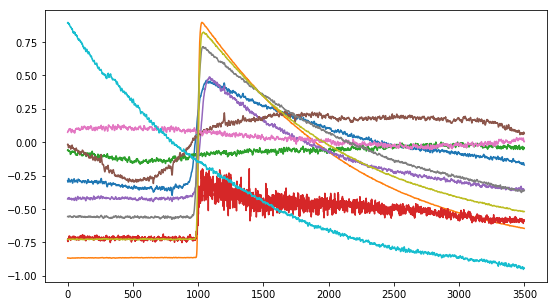

In [130]:
fig = figure(figsize=(9,5))
for i in range(k.cluster_centers_.shape[0]):
    plot(k.cluster_centers_[i])

## integrated charges to send to tom

* Energies will be 100 and 1,000 keV. This should be about 600 - 6000 keV. I'll need an energy range (I'll use about +- 600 adc ~= +- 100 keV)
* I'll undo the $\textrm{CR} - \textrm{RC}^2$ shaping to get an integrated charge pulse
* I'll first explore the data region in that range (pre shaped, making energy cuts and pulse shape cuts)

What I need to actually send: two integrated charge pulses at the different energies

## Let's get a integrated charge from this sucker

Now I want to apply the $\text{RC}^2-\text{CR}$ shaper to undo what the electronics does to the signal to get an integrated charge pulse. 

In [ ]:
@jit(nopython=True)
def rc2_cr(wf):
    wf2 = np.empty(3500)
    length = len(wf2)
    alpha_cr = 1250./(1250.+1.); #fall time of output
    alpha_rc1 = 1./2.75;
    alpha_rc2 = 1./2.75;    
    zrc1 = np.zeros(2)
    zcr = np.zeros(2)
    zcharge = np.zeros(2)
    zrc2 = wf[:2].copy()
    for i in range(length):
        zrc2[i%2] = wf[i]
        
        zrc1[i%2] = (zrc2[i%2] - zrc2[(i+1)%2])/alpha_rc2 + zrc2[(i+1)%2]
        zcr[i%2] = (zrc1[i%2] - zrc1[(i+1)%2])/alpha_rc1 + zrc1[(i+1)%2]
        zcharge[i%2] = (zcr[i%2]/alpha_cr) - zcr[(i+1)%2] + zcharge[(i+1)%2] 

        wf2[i] = zcharge[i%2]
    
    return wf2

In [ ]:
wf1 = kmean.cluster_centers_[7] # this is the most steep
wf2 = kmean.cluster_centers_[2] # this is the medium steep
wf3 = kmean.cluster_centers_[1] # this is the least steep

wf1 -= np.mean(wf1[:200])
wf2 -= np.mean(wf2[:200])
wf3 -= np.mean(wf3[:200])

ctrZ1 = rc2_cr(wf1)
ctrZ2 = rc2_cr(wf2)
ctrZ3 = rc2_cr(wf3)

ctrZ1 /= np.amax(ctrZ1)
ctrZ2 /= np.amax(ctrZ2)
ctrZ3 /= np.amax(ctrZ2)

In [ ]:
fig = figure(figsize=(12,8))
plot(ctrZ1, label='this is the most steep one')
plot(ctrZ2, label='this is the medium steep one')
plot(ctrZ3, label='this is the least steep one')

legend();

Now I can look at distributions around each point

## Let's run with more clusters and see what happens

In [ ]:
X = normBatch(X)

In [ ]:
k = MiniBatchKMeans(n_clusters=15, n_init=100).fit(X)

In [ ]:
fig = figure(figsize=(12,10))
for i in range(k.cluster_centers_.shape[0]):
    plot(k.cluster_centers_[i], label=str(i))
legend()

## Here's with a 200 ADC energy cut

In [ ]:
Cutoff = 200
k = MiniBatchKMeans(n_clusters=15, n_init=100).fit(np.array([X[i] for i in range(len(X)) if E[i]>Cutoff]))

In [ ]:
fig = figure(figsize=(12,10))
for i in range(k.cluster_centers_.shape[0]):
    plot(k.cluster_centers_[i], label=str(i))
legend()

## Let's try to find pileup

In [ ]:
Cutoff = 100
k = KMeans(n_clusters=25, n_init=10).fit(np.array([X[i] for i in range(len(X)) if E[i]>Cutoff]))

In [ ]:
fig = figure(figsize=(25,10))
for i in range(k.cluster_centers_.shape[0]):
    subplot(5,5,i+1)
    plot(k.cluster_centers_[i], label=str(i))
    legend()

None of this looks like obvious pileup, but it does look like some of the stuff Noah has talked about

ID number seven looks interesting, so let's see what's going on there

In [ ]:
weird_ones = []
for i in range(len(k.labels_)):
    if k.labels_[i]==17:
        weird_ones.append(X[i])

In [ ]:
len(weird_ones)

We'll just look at the first 25

In [ ]:
fig = figure(figsize=(25,10))
for i in range(25):
    subplot(5,5,i+1)
    plot(weird_ones[i], label=str(i))
    legend()

## Let's try Dimensionality reduction, other clustering algorithms, etc

### Try PCA on the data - it won't work

In [ ]:
from sklearn.decomposition import PCA
from scipy import stats

In [ ]:
maxDim = 20
x = X[:10*1000]
x /= np.std(x, 0)
x -= np.mean(x, 0)
res = np.empty(maxDim-1)
pca = PCA(n_components=maxDim)
pca.fit(x)
pca_score = pca.explained_variance_ratio_

for i in range(1,maxDim):
    res[i-1] = 1.0-np.sum(pca_score[:i])

In [ ]:
t = np.arange(1,maxDim)
scatter(t, res)

Cannot use PCA to get more than about 30% of the variance in the data, so eh...

Maybe I'll look at clustering them with the OPTIC algorithm

Lol, the OPTIC algorithm is experimental in sklearn, so I'll try kernel trick PCA and spectral clustering

### Maybe Kernel PCA works better?

In [ ]:
from sklearn.decomposition import KernelPCA

In [ ]:
maxDim = 20
x = X[:10*1000]
x /= np.std(x, 0)
x -= np.mean(x, 0)
res = np.empty(maxDim-1)
pca = KernelPCA(n_components=maxDim, n_jobs=4)
pca.fit(x)

In [ ]:
pca_score = pca.lambdas_

for i in range(1,maxDim):
    res[i-1] = 1.0-np.sum(pca_score[:i])

In [ ]:
t = np.arange(1,maxDim)
scatter(t, res)

So using the kernel pca with 4 dimensions may be a good reduction to make, but we'll see

Now I'm going to apply spectral clustering and see what it finds as the average pulse shape

Spectral decomposition threw a linear algebra error, so I am trying something else

DBSCAN said all samples were too noisy

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
spectre = DBSCAN(eps=3.5)

This method is taking a heck of a lot longer than k means clustering, so it had better look pretty 

In [ ]:
N = 10000

In [ ]:
spectre.fit(X[:N])

In [ ]:
list(set(spectre.labels_))

In [ ]:
numCenters = len(list(set(spectre.labels_))) -1 
spectreCenters = np.empty((numCenters,3500))
spectreCount = np.empty(numCenters)
for i in range(numCenters):
    wfSet = np.array([X[j] for j in range(len(X[:N])) if spectre.labels_[j]==i])
    spectreCount[i] = len(wfSet)/len(X[:N])
    spectreCenters[i] = np.mean(wfSet, 0)

In [ ]:
for i in range(numCenters):
    plt.plot(spectreCenters[i], label='id '+str(i)+': '+str(100*spectreCount)+'%')

In [ ]:
for i in range(numCenters):
    plt.plot(spectreCenters[i], label='id '+str(i)+': '+str(100*spectreCount)+'%')

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
spectre = AgglomerativeClustering(n_clusters=10)

In [ ]:
N = 10000

In [ ]:
spectre.fit(X[:N])

In [ ]:
list(set(spectre.labels_))

In [ ]:
numCenters = len(list(set(spectre.labels_)))
spectreCenters = np.empty((numCenters,3500))
spectreCount = np.empty(numCenters)
for i in range(numCenters):
    wfSet = np.array([X[j] for j in range(len(X[:N])) if spectre.labels_[j]==i])
    spectreCount[i] = len(wfSet)/len(X[:N])
    spectreCenters[i] = np.mean(wfSet, 0)

In [ ]:
for i in range(numCenters):
    plt.plot(spectreCenters[i], label='id '+str(i)+': '+str(100*spectreCount)+'%')

ok, wow this cannot handle the sharp variation at the start of the waveform pulse

In [ ]:
maxClusters = 40
res2 = np.empty(maxClusters-2)
for numClusters in range(2,maxClusters):
    kmean = Birch(n_clusters=numClusters,  n_jobs=4).fit(X[:1000])
    res2[numClusters-2] = kmean.score(X)

In [ ]:
t = np.arange(2, maxClusters)
plt.scatter(t, -res2)
plt.yscale('log')

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
spectre = AgglomerativeClustering(n_clusters=8, linkage='ward')

In [ ]:
N = 1000*10

In [ ]:
spectre.fit(X[:N])

In [ ]:
list(set(spectre.labels_))

In [ ]:
numCenters = len(list(set(spectre.labels_)))
spectreCenters = np.empty((numCenters,3500))
spectreCount = np.empty(numCenters)
for i in range(numCenters):
    wfSet = np.array([X[j] for j in range(len(X[:N])) if spectre.labels_[j]==i])
    spectreCount[i] = len(wfSet)/len(X[:N])
    spectreCenters[i] = np.mean(wfSet, 0)

In [ ]:
for i in range(numCenters):
    plt.plot(spectreCenters[i], label='id '+str(i)+': '+str(100*spectreCount)+'%')

In [ ]:
spectre = AgglomerativeClustering(n_clusters=15, linkage='ward')

In [ ]:
N = 1000*10

In [ ]:
spectre.fit(X[:N])

In [ ]:
list(set(spectre.labels_))

In [ ]:
numCenters = len(list(set(spectre.labels_)))
spectreCenters = np.empty((numCenters,3500))
spectreCount = np.empty(numCenters)
for i in range(numCenters):
    wfSet = np.array([X[j] for j in range(len(X[:N])) if spectre.labels_[j]==i])
    spectreCount[i] = len(wfSet)/len(X[:N])
    spectreCenters[i] = np.mean(wfSet, 0)

In [ ]:
f = plt.figure(figsize=(15,10))
for i in range(numCenters):
    plt.plot(spectreCenters[i], label='id '+str(i)+': '+str(np.around(100*spectreCount[i],2))+'%')
plt.legend()

### hmm, let's look at the pixel ids for a few steepy centers

In [ ]:
dh = np.dtype([
    ('result',np.ubyte), ('event id', 'i'), 
    ('board number', 'i4'), ('channel number', 'i4'),
    ('req. timestamp',np.uint64), ('cur timestamp',np.uint64),
    ('length', 'i4')])

In [ ]:
np.core.records.fromstring?

In [ ]:
headerInfo = np.core.records.fromstring(data['header'].copy(order='C'), dtype=dh ,shape=N)

In [ ]:
headerInfo[:10]

In [ ]:
fig = figure(figsize=(8,5))
for i in range(kmean.cluster_centers_.shape[0]):
    plot(kmean.cluster_centers_[i], label='id '+str(i)+': this is '+str(100*len(clusterE[i])/len(X))+'% of the data')
legend()

So we want ids 7, 1, 2

In [ ]:
map?

In [ ]:
from collections import Counter

In [ ]:
from enum import unique

In [ ]:
idIndexList = [7, 1, 2]
info = []

for i, idIndex in enumerate(idIndexList):
    
    BC = [(headerInfo[j]['board number'],headerInfo[j]['channel number']) for j in range(len(X)) if kmean.labels_[j]==idIndex]
    
    c = Counter(BC)
    
    total = 0   
    for i, j in c.items() :
        total += j
    
    percCovered = 0.
    percList = c.most_common()
    i = 0
    print('\n\nfor id '+str(idIndex))
    print('(board, channel) ')
    while (percCovered<0.90):
        print(str(percList[i][0])+' makes up '+str(100*np.around(percList[i][1]/total,2)), '%')
        percCovered += percList[i][1]/total
        i += 1


In [ ]:
from sklearn.cluster import MiniBatchKMeans

In [ ]:
data['wf'].shape

In [ ]:
k = MiniBatchKMeans(n_clusters=15, n_init=100).fit(data['wf'][:10**4])

In [ ]:
fig = figure(figsize=(12,10))
for i in range(k.cluster_centers_.shape[0]):
    plot(k.cluster_centers_[i], label=str(i))
legend()